In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import load_wine

Loading dataset

In [2]:
data = load_wine()
df = pd.DataFrame(data= np.c_[data['data'], data['target']], columns= data['feature_names'] + ['target'])
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


Getting one hot encoding for Output class

In [3]:
X=df.iloc[:,:-1]
Y=df.iloc[:,-1]
dat=pd.get_dummies(Y)

In [4]:
def normalize(df): #nomralising
    result = df.copy()
    for feature_name in df.columns:
        result[feature_name] = (df[feature_name] - df[feature_name].min()) / (df[feature_name].max() - df[feature_name].min())
    return result

Defining activation function and its derivative

In [5]:
def sigmoid(Z): #sigmoid function
  return 1/(1+np.exp(-Z))
def mapp(A):  #mapping maximum value in the output of one vs all for their respective class
  arr=[]
  for row in A:
    c=[]
    for col in row:
      if col>=0.5:
        c.append(1)
      else:
        c.append(0)
    arr.append(c)
  arr=np.array(arr)
  return arr  
def relu(Z):  #relu activation for hidden layers
  return np.maximum(0,Z)
def tanh(z):    #tanh activation
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def tanh_derivative(dA,z):
	return dA*(1 - np.power(tanh(z), 2))

def sigmoid_derivative(dA,A): #derivation of sigmoid function 
  return dA*A*(1-A)
def relu_derivative(dA,Z):  #derivation of relu for back propagation
  dZ=np.array(Z,copy=True)
  dZ[Z<=0]=0      
  dZ[Z>=0]=1
  return dA*dZ


Predicting function for output of the model after training weights 

In [6]:
def predict(param,X,Y,length): #prediction of model
  A=X
  for i in range(length):  # forward propagation for hidden layer
    Z=params["W"+str(i+1)]@A+params["b"+str(i+1)]
    if i+1!=length:
      if(activation[i]=="relu"):
        A=relu(Z)
      elif(activation[i]=='tanh'):
        A=tanh(Z)
      elif(activation[i]=='sigmoid'):
        A=sigmoid(Z)
  A=sigmoid(Z)      # output layer activation would be sigmoid 
  Z=Z.T
  Z=(Z == Z.max(axis=1)[:,None]).astype(int)    # find the col having largest val of calculation
  k=np.sum(np.all(Z==Y,axis=1))               # comparing row of predicted output and given output for accuracy 
  return k/len(Y)*100

Here we define the function for forward and backword propagation,<br>
For propagation for layer \[l\]:$$Z^l=W^l*A^{l-1}+b^l$$ here A0=X(input feature)
and activation:  $$A^l=G(Z^l)$$  where is activation function like relu,tanh,sigmoid <br>
For backward propagation, for last layer error would be : $$dZ=A^{output}-Y^{given}$$
and for hidden layer: $$dZ^l=W^{l+1}*dZ^{l+1}*{derivative\_of\_activation\_of\_layer [l]}$$
here we would denote: $$dA^l=W^{l+1}*dZ^{l+1}  : so ,dZ^l=dA^l*{derivative\_of\_activation\_of\_layer [l]}$$
$$dW^l=(1/m)*dZ^l*A^{l-1}$$ m=neurons in layer l
$$db^l=(1/m)*dZ^l$$

In [7]:
def deriv(derivative,dZ,pramams,length):  #backpropagation for getting derivation of Weights,bias,Z(W*A+b),A=g(Z)[activation]
  derivative["dZ"+str(length)]=dZ  
  A_p=params["A"+str(length-1)]                   ## A^{l-1}
  dW=(1/A_p.shape[1])*np.dot(dZ,A_p.T)                  ##calculating dW 
  db=(1/A_p.shape[1])*np.sum(dZ,axis=1,keepdims=True)      ## db
  dA_p=params["W"+str(length)].T@dZ                 ## dA
  derivative["dW"+str(length)]=dW
  derivative["db"+str(length)]=db
  if length-1!=0:
    derivative["dA"+str(length-1)]=dA_p              ## we do not need to find dA for input layer 

Training Model

In [8]:
def MLP(lr,iter,X,Y,para,length,activation): #traing model
  cost=[]
  for zp in range(iter):                    #epoch      
    A=X
    para["A0"]=A
    for l in range(1,length):  #forward propagation
      Z=para["W"+str(l)]@A+para["b"+str(l)]
      if(activation[l-1]=="relu"):
        A=relu(Z)
      elif(activation[l-1]=='tanh'):
        A=tanh(Z)
      elif(activation[l-1]=='sigmoid'):
        A=sigmoid(Z)
      para["Z"+str(l)]=Z
      para["A"+str(l)]=A

    Z=para["W"+str(length)]@A+para["b"+str(length)]        # forward propagation for output layer
    A=sigmoid(Z)   #output layer for one vs all model
    para["Z"+str(length)]=Z
    para["A"+str(length)]=A
    # A=mapp(A)
    derivative={}  ## dict to save all backward propagation parameters
    dZ=A-Y  #error
    
    if zp%100==0:      # finding error for every 100 iteration
        cost.append(dZ.sum())
    deriv(derivative,dZ,para,length)  # finding derivative dW,db,dA

    #back propagation to calcuale all derivative of weights,bias,Z,A  for hidden layer
    for l in reversed(range(length-1)): 
        # #back propagation for hidden layer
      if(activation[l]=="relu"):
        dZ=relu_derivative(derivative["dA"+str(l+1)],para["Z"+str(l+1)])
      elif(activation[l]=='tanh'):
        dZ=tanh_derivative(derivative["dA"+str(l+1)],para["Z"+str(l+1)])
      elif(activation[l]=='sigmoid'):
        dZ=sigmoid_derivative(derivative["dA"+str(l+1)],para["Z"+str(l+1)])
      
      deriv(derivative,dZ,para,l+1)   # find dW,db for hidden layer
    
    #updating weights
    for i in range(length): 
      para["W"+str(i+1)]-=lr*derivative["dW"+str(i+1)]
      para["b"+str(i+1)]-=lr*derivative["db"+str(i+1)]
  return para,cost

1. input the number of features, number of hidden layer for the model, number of neurons in hidden layer , enter the number of iterations(epoch), eter the learning rate .
2. Initializing the weights, the shape of weights for layer 'l' is initialized as:<br>
                       w\[l\]=\[number of neurons in layer l, neurons in layer l-1\]*(sqrt(1/neurons in layer \[l\],neurons in layer \[l-1\]))<br>
3. Trainig model with MLP 
   
Uncomment the lines for taking hidden layers,number of neurons and activation for each layer  

In [9]:

layers_neuron=[X.shape[1],50,30]   # layer_neuron=[], before taking input
# f=int(input("Enter the number of features:"))

# layers_neuron.append(f)
# x=int(input('Enter the nuber of hidden layer u want:'))
# for i in range(x):
#   y=int(input("enter the number of neurons in layer {}:".format(i+1)))
#   layers_neuron.append(y)
layers_neuron.append(len(Y.unique()))
# lr=float(input("enter the learning rate:"))
lr=0.1
# epoch=int(input("enter the epoch:")
epoch=2000
activation=['tanh','relu']      # activation=[],before taking input
# for i in range(x):
#   y=str(input("Enter the activation for hidden layer {}:".format(i+1)))
#   activation.append(y)
X_train,X_test,Y_train,Y_test=train_test_split(X,dat,train_size=0.8,shuffle=True)
X_train=normalize(X_train)
X_test=normalize(X_test)
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_train=Y_train.to_numpy()
y_test=Y_test.to_numpy()

params={} ## dict to save all forward propagation parameters
for i in range(1,len(layers_neuron)):  #initializing weights for layers
  params["W"+str(i)]=np.random.rand(layers_neuron[i],layers_neuron[i-1])*(np.sqrt(2/(layers_neuron[i-1]+layers_neuron[i])))
  params["b"+str(i)]=np.ones((layers_neuron[i],1))
length=len(params)//2   #number of layers

param,error=MLP(lr,epoch,X_train.T,y_train.T,params,length,activation) #training model
#getting the accuracy 
TEA=round(predict(param,X_test.T,y_test,length),2)
TRA=round(predict(param,X_train.T,y_train,length),2)
print("test accuracy ",TEA,"%")
print("train accuracy ",TRA,"%")



test accuracy  94.44 %
train accuracy  100.0 %


In [10]:
iter=[x*100 for x in range(int(epoch/100)) ]

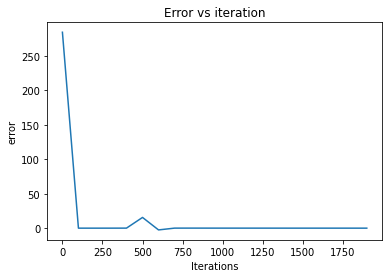

In [11]:
plt.plot(iter,error)
plt.xlabel('Iterations')
plt.ylabel('error')
plt.title("Error vs iteration")
plt.show()

We have trained our model on MLP and get the accuracy 94% for test dateset, and above plot represents how the error is decreasing with the iterations